# **Lorem Ipsum Dolor Sit Amet**

Lorem ipsum dolor sit amet, consectetur adipiscing elit. Donec vestibulum tortor tortor, sed lobortis velit pharetra et. Mauris at lectus quis lorem viverra cursus. Praesent a efficitur lectus, vitae aliquet urna. Phasellus aliquam felis non consequat eleifend. Nulla ut feugiat ex. Suspendisse non justo vel neque dignissim vestibulum. Praesent feugiat vel nisi eu ullamcorper. Sed tincidunt mollis ex. 

**Authors:**
- [Adrian Flores](https://github.com/adrianRFlores)
- [Andrea Ramirez](https://github.com/Andrea-gt)

***

## **(1) Import Libraries** ⬇️

In [122]:
#!pip install unidecode

In [123]:
# Data manipulation and visualization
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from unidecode import unidecode
import json
import nltk
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords
from fuzzywuzzy import process, fuzz
from wordcloud import WordCloud

# Standard libraries
import warnings
warnings.filterwarnings('ignore')

# ===== ===== Reproducibility Seed ===== =====
# Set a fixed seed for the random number generator for reproducibility
random_state = 42

# Set matplotlib inline
%matplotlib inline

# Set default figure size
plt.rcParams['figure.figsize'] = (6, 4)

# Define custom color palette
palette = sns.color_palette("viridis", 12)

# Set the style of seaborn
sns.set(style="whitegrid")

## **(2) Data Upload** 📄

In [124]:
# Read the .txt file 
with open('data/tweets.txt', 'r', encoding='utf-16') as file:
    lines = file.readlines()

In [125]:
# List to hold extracted tweet data
tweet_data = []

# Loop through each line, assuming each line is a separate JSON object
for line in lines:
    # Parse the line as JSON
    data = json.loads(line.strip())
    
    # Extract the relevant information
    tweet_entry = {
        "tweet_date": pd.to_datetime(data["date"]).date(),
        "user_username": data["user"]["username"],
        "mentioned_users": ", ".join([user["username"] for user in data["mentionedUsers"]]),
        "reply_count": data["replyCount"],
        "retweet_count": data["retweetCount"],
        "like_count": data["likeCount"],
        "quote_count": data["quoteCount"],
        'tweet': data['rawContent'],
        "hashtags": ", ".join(data["hashtags"])
    }
    
    # Append the tweet data to the list
    tweet_data.append(tweet_entry)

In [126]:
# Create the DataFrame
df = pd.DataFrame(tweet_data)

# Display the DataFrame
df.head(3)

,tweet_date,user_username,mentioned_users,reply_count,retweet_count,like_count,quote_count,tweet,hashtags
0,2024-09-12,La_ReVoluZzion,"usembassyguate, 48CantonesToto, USAIDGuate, UE...",0,0,0,0,"_\nConfirmado Compañeres,\n\nEl impuesto por l...",
1,2024-09-12,XelaNewsGt,,12,80,142,15,#URGENTE Lo que los medios #faferos no informa...,"URGENTE, faferos, BernardoArévalo, NebajQuiché..."
2,2024-09-12,M24095273,"IvanDuque, BArevalodeLeon",0,0,0,0,@IvanDuque @BArevalodeLeon Con que usaste PEGA...,


**Observaciones 💡 -->**

Notar que ya se han llevado a cabo algunas acciones importantes de pre-procesamiento con el objetivo de optimizar el conjunto de datos, en el contexto del análisis de redes sociales (esto puede variar según el propósito del dataset). A continuación, se detallan los pasos realizados:

> - **Reducción de columnas:** Se han eliminado aquellas columnas que no aportan valor relevante para el análisis de redes sociales, dejando únicamente las siguientes variables: tweet_date, user_username, mentioned_users, reply_count, retweet_count, like_count, quote_count, tweet y hashtags. La finalidad es reducir la dimensionalidad del conjunto de datos, eliminando características que solo añaden ruido innecesario.

> - **Formateo de fecha:** La columna tweet_date, que originalmente incluía tanto la fecha como la hora, ha sido simplificada para contener únicamente el día, mes y año. Este ajuste es especialmente útil dado que la precisión horaria no es relevante para el análisis, contribuyendo así a la homogeneización del formato de los datos.

## **(3) Exploratory Analysis** 🔎

### **(1) Descripción General de los Datos**

In [127]:
# Print the number of records in the DataFrame
print("The given dataset has", df.shape[0], "registers and", df.shape[1], "columns.")

The given dataset has 5019 registers and 9 columns.


**Observaciones 💡 -->**

> - El conjunto de datos actual cuenta con 5019 registros y las 9 columnas previamente mencionadas, indicando una dimensión relativamente pequeña. Este conjunto de datos consta de tweets de la plataforma `X`, que de alguna u otra forma están ligados a el usuario `@BArevalodeLeon`. Cada uno de los 7613 registros representa un tweet único, mientras que las 9 columnas corresponden a diferentes características o variables medidas para cada observación, incluyendo el texto y fecha de un tweet, así como las estadísticas de este.

In [128]:
# Basic information about the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5019 entries, 0 to 5018
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   tweet_date       5019 non-null   object
 1   user_username    5019 non-null   object
 2   mentioned_users  5019 non-null   object
 3   reply_count      5019 non-null   int64 
 4   retweet_count    5019 non-null   int64 
 5   like_count       5019 non-null   int64 
 6   quote_count      5019 non-null   int64 
 7   tweet            5019 non-null   object
 8   hashtags         5019 non-null   object
dtypes: int64(4), object(5)
memory usage: 353.0+ KB


**Observaciones 💡 -->**

> - Por el momento, no se ha detectado la presencia de valores faltantes  en ninguna de las columnas. Sin embargo, es evidente que sí existe información ausente en algunos registros, lo que sugiere que será necesario realizar un preprocesamiento adicional para identificar adecuadamente estos datos faltantes. Una vez detectados, será importante aplicar técnicas de imputación que permitan completar o manejar estos valores de manera adecuada.

El conjunto de datos contiene 9 columnas o características, las cuales se describen a continuación:

- **tweet_date**: La fecha en la que se publicó el tweet.
- **user_username**: El nombre de usuario de la cuenta que publicó el tweet. 
- **mentioned_users**: Los usuarios mencionados en el tweet. 
- **reply_count**: El número de respuestas que recibió el tweet. 
- **retweet_count**: La cantidad de veces que el tweet fue retuiteado. 
- **like_count**: El número de "me gusta" que recibió el tweet. 
- **quote_count**: La cantidad de veces que el tweet fue citado. 
- **tweet**: El contenido textual del tweet.
- **hashtags**: Los hashtags incluidos en el tweet.

Las características incluyen tanto datos de tipo numérico (`int64`) como de tipo texto (`object`).

### **(2) Clasificación de las Variables**

| **Nombre de la columna** | **Descripción**                                                  | **Clasificación**                   |
|--------------------------|------------------------------------------------------------------|-------------------------------------|
| `tweet_date`             | Fecha en la que se publicó el tweet                              | Cualitativa (descriptiva)           |
| `user_username`          | Nombre de usuario de la cuenta que publicó el tweet              | Cualitativa (descriptiva)           |
| `mentioned_users`        | Usuarios mencionados en el tweet                                 | Cualitativa (descriptiva)           |
| `reply_count`            | Número de respuestas que recibió el tweet                        | Cuantitativa (discreta)             |
| `retweet_count`          | Número de veces que fue retuiteado el tweet                      | Cuantitativa (discreta)             |
| `like_count`             | Número de "me gusta" que recibió el tweet                        | Cuantitativa (discreta)             |
| `quote_count`            | Número de veces que fue citado el tweet                          | Cuantitativa (discreta)             |
| `tweet`                  | Contenido textual del tweet                                      | Cualitativa (descriptiva)           |
| `hashtags`               | Hashtags incluidos en el tweet                                   | Cualitativa (descriptiva)           |


**Observaciones 💡 -->**

> - El conjunto de datos posee 5 variables cualitativas descriptivas.
> - Las últimas 4 variables del conjunto de datos son de tipo cuantitativo.

### **(3) Exploración y Limpieza Inicial de los Datos**

#### **(1) Preprocesamiento de los Datos**

In [129]:
# Download the NLTK stopwords if not already available
nltk.download('stopwords')
# Initialize the PorterStemmer
stemmer = SnowballStemmer('spanish')

[nltk_data] Downloading package stopwords to /home/andrea/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [130]:
# Get the list of stopwords from NLTK
stop_words = set(stopwords.words('spanish'))

In [131]:
# Function to remove stopwords and apply stemming
def preprocess_text(text):
    # Tokenize the text
    words = text.split()
    # Remove stopwords and apply stemming
    processed_words = [word for word in words if word not in stop_words]
    # Reassemble the text
    return ' '.join(processed_words)

**Columna `tweet` -->** 

In [132]:
# Convert all entries to strings
df['tweet'] = df['tweet'].astype(str)
# Remove leading/trailing whitespaces
df['tweet'] = df['tweet'].str.strip()
# Remove accents and/or special characters
df['tweet'] = df['tweet'].apply(unidecode)
# Convert to lowercase
df['tweet'] = df['tweet'].str.lower()
# Remove usernames from the tweet text
df['tweet'] = df['tweet'].str.replace(r'@\w+', '', regex=True).str.strip()
# Remove URLs
df['tweet'] = df['tweet'].str.replace(r'http\S+|www\S+|https\S+', '', case=False, regex=True)
# Keeping letters, numbers, and spaces
df['tweet'] = df['tweet'].str.replace(r'[^\w\s]', '', regex=True)
# Remove extra spaces
df['tweet'] = df['tweet'].str.replace(r'\s+', ' ', regex=True)
# Apply preprocessing (stopwords removal and stemming)
df['tweet'] = df['tweet'].apply(preprocess_text)

**Columna `hashtags` -->** 

In [133]:
# Convert all entries to strings
df['hashtags'] = df['hashtags'].astype(str)
# Remove leading/trailing whitespaces
df['hashtags'] = df['hashtags'].str.strip()
# Remove accents and/or special characters
df['hashtags'] = df['hashtags'].apply(unidecode)
# Convert to lowercase
df['hashtags'] = df['hashtags'].str.lower()
# Remove extra spaces
df['hashtags'] = df['hashtags'].str.replace(r'\s+', '', regex=True)

**Observaciones 💡 -->**

A continuación, se describen los pasos realizados y sus justificaciones:

1. **Conversión a Cadena de Texto**: Asegura que todas las entradas sean tratadas de manera uniforme, evitando errores en operaciones posteriores.

2. **Eliminación de Espacios en Blanco**: Previene inconsistencias que podrían afectar el análisis, garantizando que cada entrada esté limpia.

3. **Eliminación de Acentos y Caracteres Especiales**: Normaliza los caracteres, facilitando la comparación entre palabras que pueden tener variantes acentuadas.

4. **Conversión a Minúsculas**: Reduce la variabilidad en los datos, asegurando que palabras como "Hola" y "hola" sean tratadas de manera consistente.

5. **Eliminación de Nombres de Usuario**: Permite centrarse en el contenido del mensaje en lugar de las interacciones entre usuarios, ya que tenemos estas interacciones almacenadas ya en otra columna.

6. **Eliminación de URLs**: Evita incluir enlaces que no aportan valor al análisis de sentimiento o contenido, enfocándose en el texto relevante.

7. **Eliminación de Caracteres Especiales**: Mantiene solo letras, números y espacios, eliminando el ruido que podría afectar la calidad del análisis.

8. **Eliminación de Espacios Adicionales**: Asegura que el texto final esté bien formado, facilitando la tokenización y otras operaciones de procesamiento.

9. **Aplicación de Preprocesamiento Adicional**: Incluye la eliminación de palabras vacías y la reducción a la raíz de las palabras, concentrándose en términos significativos y reduciendo la dimensionalidad del texto.

**Nota:**

1. La eliminación de **stopwords** filtra palabras comunes que, aunque frecuentes, aportan poco valor semántico al análisis, como "y", "el", "en", entre otras. Al excluir estas palabras, se enfoca el modelo en términos más significativos, lo que puede resultar en una mejora notable en la precisión y eficiencia del análisis textual. Sin embargo, el beneficio más grande es la reducción de dimensionalidad, permitiendo que el entrenamiento sea más rápido. [[Referencia]](https://towardsdatascience.com/text-pre-processing-stop-words-removal-using-different-libraries-f20bac19929a)

2. Para algunas de las tareas de procesamiento de lenguaje natural descritas con anterioridad, se optó por implementar nltk, para más información por favor ingresar a la documentación oficial en el siguiente [enlace](https://www.nltk.org/).

**Valores Faltantes -->** 

In [134]:
# Replace entries that are empty or contain only whitespace with np.nan
df = df.replace(r'^\s*$', np.nan, regex=True)

**Observaciones 💡 -->**

> - Esto nos permite identificar con precisión los valores faltantes y facilita la realización de imputaciones adecuadas en etapas posteriores, en caso de que sea necesario.

In [135]:
df.isnull().sum()

tweet_date            0
user_username         0
mentioned_users     183
reply_count           0
retweet_count         0
like_count            0
quote_count           0
tweet               364
hashtags           4771
dtype: int64

In [136]:
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

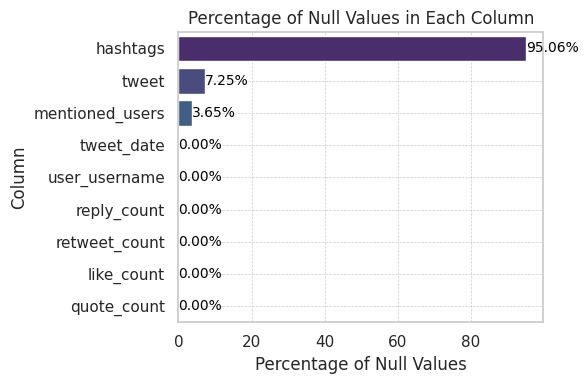

In [137]:
# Calculate the percentage of null values in each column
null_percentage = (df.isnull().sum() / len(df)) * 100

# Sort the null_percentage Series from highest to lowest
null_percentage_sorted = null_percentage.sort_values(ascending=False)

# Create a horizontal bar chart
ax = sns.barplot(x=null_percentage_sorted.values, y=null_percentage_sorted.index, palette='viridis')

# Add percentage in each bar
for bar in ax.patches:
    width = bar.get_width()
    ax.text(width, bar.get_y() + bar.get_height() / 2,
            '{:.2f}%'.format(width),
            ha='left', va='center', color='black', fontsize=10)

plt.xlabel("Percentage of Null Values")  # Updated label
plt.ylabel("Column")  # Updated label
plt.title("Percentage of Null Values in Each Column")  # Fixed closing quote

# Adding grid with custom style
plt.grid(True, linestyle='--', linewidth=0.5)  # Adding grid with dashed lines and custom line width

# Show the plot
plt.tight_layout()  # Adjust layout
plt.show()

**Observaciones 💡 -->**

> - Observamos que la columna hashtags presenta más del 95% de datos faltantes. Aunque esto sugiere que podría no ser útil, en lugar de eliminarla, considero que podríamos imputar los valores o analizar la posibilidad de utilizarla para extraer información adicional. Esto podría enriquecer nuestro análisis sin perder la columna por completo.

In [138]:
# Replace entries that are empty or contain only whitespace with np.nan
df = df.replace(np.nan, 'None')

#### **(2) Exploración de los Datos**

##### **(1) ¿Cómo se distribuye la longitud de los tweets y qué tendencias podemos identificar?**

In [139]:
# Calculate the length of text entries in the 'text' column.
length = df["tweet"].apply(len)
# Display descriptive statistics of text lengths.
print("President Tweet Set: Tweet Length Statistics")
print(length.describe())

President Tweet Set: Tweet Length Statistics
count    5019.000000
mean       73.035067
std        68.881973
min         1.000000
25%        25.000000
50%        55.000000
75%       108.000000
max      1542.000000
Name: tweet, dtype: float64


**Observaciones 💡 -->**

> - La longitud promedio de los tweets es de aproximadamente 73 caracteres, lo que sugiere que la mayoría de los tweets son relativamente cortos. 

> - La desviación estándar es de aproximadamente 68.88, lo que indica una variabilidad considerable en la longitud de los tweets. Esto sugiere que algunos tweets son mucho más largos o más cortos que la media, lo que puede influir en la forma en que se interpretan. 

> - Al analizar las longitudes extremas, se observa que el tweet más corto tiene solo 1 carácter, mientras que el más largo alcanza los 1542 caracteres. Esta variabilidad extrema resalta que, aunque la mayoría de los tweets son breves, existen excepciones significativas que pueden contener información valiosa o contexto adicional.

##### **(2) ¿Cómo se distribuyen las estadísticas de los tweets y qué tendencias podemos identificar?**

In [140]:
numeric  = df.select_dtypes(include='number')
numeric.describe()

,reply_count,retweet_count,like_count,quote_count
count,5019.000000,5019.000000,5019.000000,5019.000000
mean,7.408249,21.775254,109.174935,1.780634
std,110.363737,279.448721,1869.974212,25.948332
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,2.000000,0.000000
max,4783.000000,8307.000000,67416.000000,1336.000000


**Observaciones 💡 -->**

> - El promedio de respuestas es de 7.41, mientras que el de retweets es de 21.78 y el de likes asciende a 109.17. El número promedio de citas es de 1.78. Sin embargo, estos promedios son engañosos debido a la alta desviación estándar y la distribución sesgada, lo que sugiere que solo una pequeña parte de los tweets genera una cantidad significativa de interacciones. La mayoría de los tweets probablemente están por debajo de estos valores.

> - La desviación estándar es considerablemente alta en todas las categorías, especialmente en likes (1869.97) y retweets (279.45). Esto indica una gran dispersión de los datos, con algunos tweets obteniendo miles de interacciones, mientras que muchos otros obtienen muy pocas o ninguna. 

> - La mediana en todas las categorías es 0, lo que significa que más del 50% de los tweets no reciben ninguna respuesta, retweet, like o cita. Esto confirma que, aunque algunos tweets obtienen una cantidad significativa de interacciones, la mayoría no genera ningún tipo de respuesta por parte de los usuarios.

> - Las interacciones máximas muestran algunos valores extremadamente altos, como 4783 respuestas, 8307 retweets, 67416 likes y 1336 citas en un solo tweet. Estos valores sugieren que algunos tweets excepcionales lograron una viralidad considerable, lo que elevó los promedios y amplió la desviación estándar.

##### **(3) ¿Cuáles son los hashtags más utilizados y qué patrones se pueden observar en su uso?**

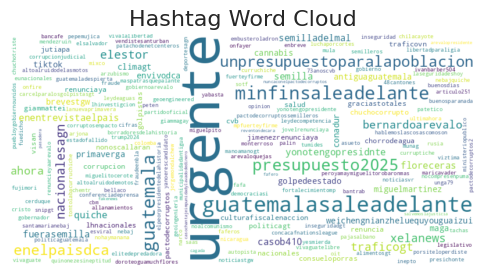

In [141]:
from collections import Counter

# Split the hashtags by comma and flatten the list
all_hashtags = df['hashtags'].str.cat(sep=',').split(',')
all_hashtags = [hashtag.strip() for hashtag in all_hashtags if hashtag.strip().lower() != 'none']  # Remove leading/trailing spaces and filter out 'None'

# Step 2: Count the frequency of each hashtag
hashtag_counts = Counter(all_hashtags)

# Step 3: Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(hashtag_counts)

# Plot the word cloud
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Turn off the axis
plt.title("Hashtag Word Cloud", fontsize=16)
plt.show()

**Observaciones 💡 -->**

> - Los hashtags más frecuentes en el conjunto de datos incluyen #GuatemalaSaleAdelante, #Urgente, #MinFinSaleAdelante, y #Presupuesto2025, entre otros. Estos hashtags no solo reflejan temas de interés nacional y política fiscal, sino también campañas o movimientos impulsados por el gobierno o medios de comunicación. Su popularidad sugiere que el contenido está vinculado a eventos actuales y temas de relevancia social y económica en Guatemala.

##### **(4) ¿Cuáles son las palabras más utilizadas en los tweets y qué patrones se pueden observar en su uso?**

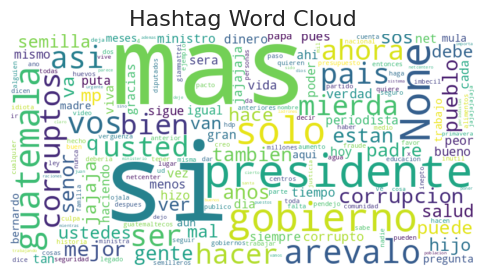

In [149]:
# Split the tweets by comma and flatten the list
all_words = df['tweet'].str.cat(sep=' ').split(' ')

# Step 2: Count the frequency of each hashtag
word_counts = Counter(all_words)

# Step 3: Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_counts)

# Plot the word cloud
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Turn off the axis
plt.title("Hashtag Word Cloud", fontsize=16)
plt.show()